# 8 Pilares Estadisticos: Evaluacion del FSI (Financial Sustainability Index)

**Traduciendo conceptos academicos para Data Science al mundo real**

Este notebook evalua el Dataset Final procesado por `ETL_Principales.py`, aplicando los 8 pilares estadisticos fundamentales para analizar la sostenibilidad financiera de Mexico:

1. **Distribuciones** - Forma de los datos
2. **Centro de Gravedad** - Media, Mediana, Moda
3. **Fiabilidad** - Riesgo y volatilidad
4. **Margen de Error** - Intervalos de confianza
5. **Pruebas de Hipotesis** - Chi-cuadrada
6. **Regresion/Prediccion** - Machine Learning
7. **Series de Tiempo** - Tendencias y estacionalidad
8. **ANOVA** - Comparacion entre grupos

**Variables clave del FSI:**
- Deuda Publica (total, LP, CP)
- Balance Fiscal
- PIB
- Balanza de Pagos
- Indicadores Macroeconomicos (inflacion, tasas, tipo de cambio)

In [1]:
# Importaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from scipy.stats import chi2_contingency, shapiro, normaltest, kruskal
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

# Configuracion de graficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Rutas
BASE_DIR = Path('..').resolve()
DATOS_RESULTADO = BASE_DIR / 'Datos_Resultado' / 'DatasetFinal'

print(f"Directorio base: {BASE_DIR}")
print(f"Datos resultado: {DATOS_RESULTADO}")

Directorio base: C:\Users\ARTUROJF\Desktop\Final
Datos resultado: C:\Users\ARTUROJF\Desktop\Final\Datos_Resultado\DatasetFinal


## Carga de Datos

Cargamos el Dataset Final procesado por ETL_Principales.py

In [2]:
# ============================================================================
# CARGAR DATOS PROCESADOS
# ============================================================================

path_procesado = DATOS_RESULTADO / 'DatasetFinal_USD_Corrientes.csv'
df = pd.read_csv(path_procesado) if path_procesado.exists() else pd.DataFrame()

print(f"Datos procesados: {len(df)} filas x {len(df.columns)} columnas")
print(f"\nColumnas disponibles:")
for i, col in enumerate(df.columns):
    print(f"  {i+1}. {col}")

Datos procesados: 92 filas x 57 columnas

Columnas disponibles:
  1. periodo
  2. year
  3. quarter
  4. inpc_q_eoq
  5. inpc_q_avg
  6. inflacion_yoy_eoq
  7. inflacion_yoy_avg
  8. PIB_USD_corriente
  9. ingresos_mmxn_USD_corriente
  10. gasto_mmxn_USD_corriente
  11. balance_mmxn_USD_corriente
  12. rfsp_total_miles_mxn_USD_corriente
  13. rfsp_sin_ingresos_rec_miles_USD_corriente
  14. balance_tradicional_miles_USD_corriente
  15. ingresos_totales_miles_USD_corriente
  16. gasto_totales_miles_USD_corriente
  17. incurrimiento_neto_pasivos_miles_USD_corriente
  18. adq_neta_activos_fin_miles_USD_corriente
  19. deuda_total_economia_musd
  20. deuda_bruta_publica_musd
  21. activos_fx_publico_musd
  22. posicion_neta_publico_musd
  23. deuda_publica_lp_musd
  24. deuda_publica_cp_musd
  25. deuda_gob_federal_musd
  26. deuda_organismos_empresas_musd
  27. deuda_banca_desarrollo_musd
  28. endeudamiento_neto_total_musd
  29. endeudamiento_neto_lp_musd
  30. endeudamiento_neto_cp_musd


In [3]:
# Preparar datos para analisis
df['periodo'] = pd.to_datetime(df['periodo'])
df = df.sort_values('periodo').reset_index(drop=True)

# Crear columna TRIMESTRE si no existe
if 'TRIMESTRE' not in df.columns:
    df['TRIMESTRE'] = df['quarter'] if 'quarter' in df.columns else df['periodo'].dt.quarter

# Variables clave para FSI
vars_fsi = {
    'Deuda': ['deuda_bruta_publica_musd', 'deuda_publica_lp_musd', 'deuda_publica_cp_musd'],
    'Fiscal': ['balance_mmxn_USD_corriente', 'ingresos_mmxn_USD_corriente', 'gasto_mmxn_USD_corriente'],
    'Macro': ['PIB_USD_corriente', 'inflacion_yoy_eoq', 'TasaMXN', 'tcn_mean'],
    'Externo': ['CuentaCorriente', 'Exportaciones', 'Importaciones', 'Remesas']
}

# Filtrar variables disponibles
for cat, vars_list in vars_fsi.items():
    vars_fsi[cat] = [v for v in vars_list if v in df.columns]
    print(f"{cat}: {len(vars_fsi[cat])} variables")

# Variable principal: Deuda Bruta Publica
VAR_PRINCIPAL = 'deuda_bruta_publica_musd'
print(f"\nVariable principal: {VAR_PRINCIPAL}")
print(f"Rango: {df[VAR_PRINCIPAL].min():,.0f} - {df[VAR_PRINCIPAL].max():,.0f} millones USD")

df.head()

Deuda: 3 variables
Fiscal: 3 variables
Macro: 4 variables
Externo: 4 variables

Variable principal: deuda_bruta_publica_musd
Rango: 54,766 - 229,061 millones USD


,periodo,year,quarter,inpc_q_eoq,inpc_q_avg,inflacion_yoy_eoq,inflacion_yoy_avg,PIB_USD_corriente,ingresos_mmxn_USD_corriente,gasto_mmxn_USD_corriente,...,Importaciones,BalanzaBienes,BalanzaServicios,BalanzaIngresoPrimario,BalanzaIngresoSecundario,TasaMXN,TasaUSD,tcn_mean,tcn_eop,TRIMESTRE
0,2002-01-01,2002,1,51.1279,50.9654,4.66,4.75,802045.789982,34.452087,35.003462,...,38121.517,-1431.944326,-520.406919,-3983.807510,2309.064989,NaN,1.7333,9.1135,9.0771,1
1,2002-04-01,2002,2,51.7626,51.5604,4.94,4.77,838789.778616,37.692969,34.478423,...,42977.609,-1492.583948,-1439.292142,-1807.734396,2707.487464,NaN,1.7500,9.4677,9.7502,2
2,2002-07-01,2002,3,52.4220,52.1472,4.95,5.25,805821.179277,35.043520,36.473351,...,42925.083,-1571.399636,-1182.674365,-2637.059303,2679.557808,NaN,1.7400,9.8925,10.0554,3
3,2002-10-01,2002,4,53.3099,53.0139,5.70,5.34,795432.261132,36.358533,44.617164,...,44654.680,-3139.032399,-1416.955874,-2112.152543,2640.887562,NaN,1.4433,10.1688,10.2103,4
4,2003-01-01,2003,1,54.0129,53.7375,5.64,5.44,748156.515839,37.376589,34.456947,...,39189.409,-137.159866,-709.201785,-4158.363918,3304.420496,NaN,1.2500,10.8181,10.9246,1


In [4]:
# Crear indicadores derivados importantes
if 'PIB_USD_corriente' in df.columns and VAR_PRINCIPAL in df.columns:
    df['deuda_pib_ratio'] = df[VAR_PRINCIPAL] / df['PIB_USD_corriente'] * 100
    print(f"Ratio Deuda/PIB: {df['deuda_pib_ratio'].min():.1f}% - {df['deuda_pib_ratio'].max():.1f}%")

if 'balance_mmxn_USD_corriente' in df.columns and 'PIB_USD_corriente' in df.columns:
    df['balance_pib_ratio'] = df['balance_mmxn_USD_corriente'] / df['PIB_USD_corriente'] * 100
    print(f"Ratio Balance/PIB: {df['balance_pib_ratio'].min():.1f}% - {df['balance_pib_ratio'].max():.1f}%")

# Lista de todas las variables numericas para analisis
cols_numericas = []
for vars_list in vars_fsi.values():
    cols_numericas.extend(vars_list)
cols_numericas = list(set(cols_numericas))
print(f"\nTotal variables para analisis: {len(cols_numericas)}")

Ratio Deuda/PIB: 4.4% - 24.6%
Ratio Balance/PIB: -0.0% - 0.0%

Total variables para analisis: 14


---
## PILAR 1: Distribuciones - ¿Que forma tienen los datos?

**Objetivo:** Identificar si los datos siguen una distribucion normal o requieren transformacion.

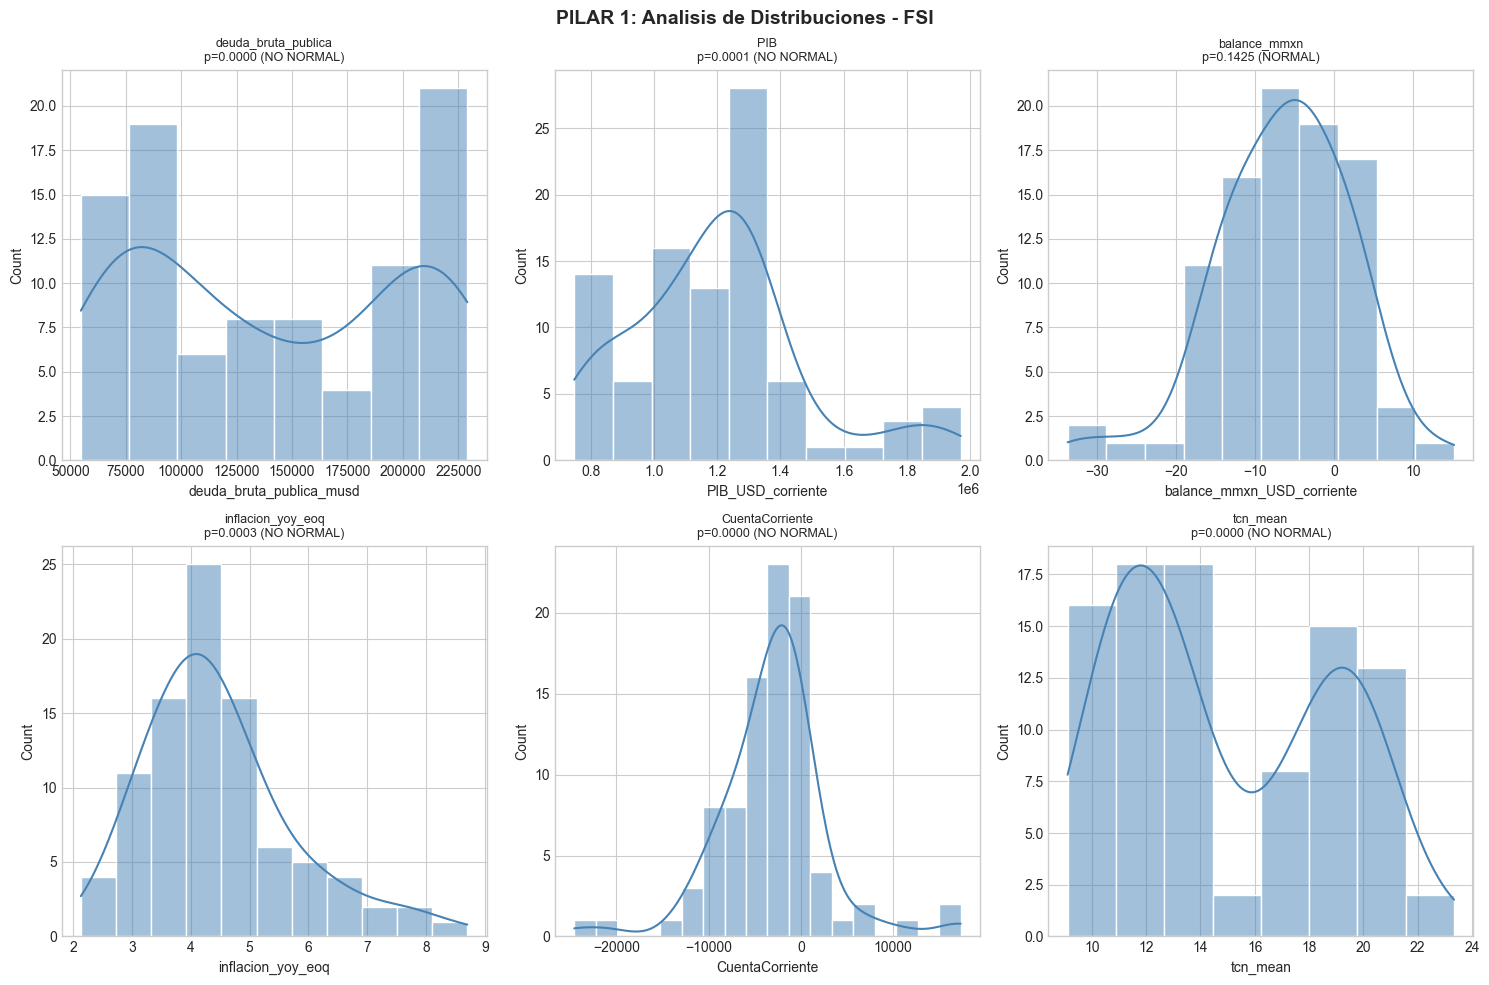


RESUMEN DE NORMALIDAD - VARIABLES CLAVE FSI
deuda_bruta_publica_musd            | p=0.0000 | Sesgo=  0.09 | Kurt= -1.59 | No Normal
PIB_USD_corriente                   | p=0.0001 | Sesgo=  0.73 | Kurt=  0.79 | No Normal
balance_mmxn_USD_corriente          | p=0.1425 | Sesgo= -0.51 | Kurt=  0.99 | Normal
inflacion_yoy_eoq                   | p=0.0003 | Sesgo=  1.01 | Kurt=  1.13 | No Normal
CuentaCorriente                     | p=0.0000 | Sesgo=  0.11 | Kurt=  4.30 | No Normal
tcn_mean                            | p=0.0000 | Sesgo=  0.32 | Kurt= -1.41 | No Normal


In [5]:
# ============================================================================
# PILAR 1: DISTRIBUCIONES
# ============================================================================

# Seleccionar variables clave para visualizacion
vars_visualizar = ['deuda_bruta_publica_musd', 'PIB_USD_corriente', 'balance_mmxn_USD_corriente', 
                   'inflacion_yoy_eoq', 'CuentaCorriente', 'tcn_mean']
vars_visualizar = [v for v in vars_visualizar if v in df.columns]

n_vars = len(vars_visualizar)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('PILAR 1: Analisis de Distribuciones - FSI', fontsize=14, fontweight='bold')

for idx, var in enumerate(vars_visualizar):
    ax = axes[idx // 3, idx % 3]
    data = df[var].dropna()
    
    # Histograma con KDE
    sns.histplot(data, kde=True, ax=ax, color='steelblue', edgecolor='white')
    
    # Test de normalidad
    if len(data) >= 20:
        stat, p_value = shapiro(data) if len(data) < 5000 else normaltest(data)
        normalidad = 'NORMAL' if p_value > 0.05 else 'NO NORMAL'
        ax.set_title(f'{var.replace("_USD_corriente", "").replace("_musd", "")}\np={p_value:.4f} ({normalidad})', fontsize=9)
    else:
        ax.set_title(f'{var}\n(datos insuficientes)', fontsize=9)

plt.tight_layout()
plt.show()

# Resumen de normalidad
print("\n" + "="*70)
print("RESUMEN DE NORMALIDAD - VARIABLES CLAVE FSI")
print("="*70)
for var in vars_visualizar:
    data = df[var].dropna()
    if len(data) >= 20:
        stat, p = shapiro(data) if len(data) < 5000 else normaltest(data)
        skew = data.skew()
        kurt = data.kurtosis()
        print(f"{var[:35]:35} | p={p:.4f} | Sesgo={skew:6.2f} | Kurt={kurt:6.2f} | {'Normal' if p>0.05 else 'No Normal'}")

---
## PILAR 2: Centro de Gravedad - ¿Donde esta el comportamiento tipico?

**Objetivo:** Identificar Media, Mediana y Moda de las variables principales.

In [6]:
# ============================================================================
# PILAR 2: CENTRO DE GRAVEDAD
# ============================================================================

print("PILAR 2: MEDIDAS DE TENDENCIA CENTRAL")
print("="*80)

# Calcular estadisticas para variables clave
stats_centro = []
for var in vars_visualizar:
    data = df[var].dropna()
    if len(data) > 0:
        stats_centro.append({
            'Variable': var.replace('_USD_corriente', '').replace('_musd', ''),
            'Media': data.mean(),
            'Mediana': data.median(),
            'Desv. Std': data.std(),
            'Dif. Media-Med (%)': ((data.mean() - data.median()) / abs(data.median()) * 100) if data.median() != 0 else 0
        })

df_centro = pd.DataFrame(stats_centro)
print(df_centro.to_string(index=False))

PILAR 2: MEDIDAS DE TENDENCIA CENTRAL
           Variable         Media       Mediana     Desv. Std  Dif. Media-Med (%)
deuda_bruta_publica  1.410264e+05  1.279601e+05  61237.345267           10.211155
                PIB  1.195386e+06  1.206786e+06 275130.851705           -0.944637
       balance_mmxn -6.323902e+00 -5.674672e+00      8.470421          -11.440838
  inflacion_yoy_eoq  4.476304e+00  4.240000e+00      1.290120            5.573216
    CuentaCorriente -3.092619e+03 -2.536548e+03   5880.025647          -21.922359
           tcn_mean  1.492747e+01  1.324690e+01      3.864761           12.686545


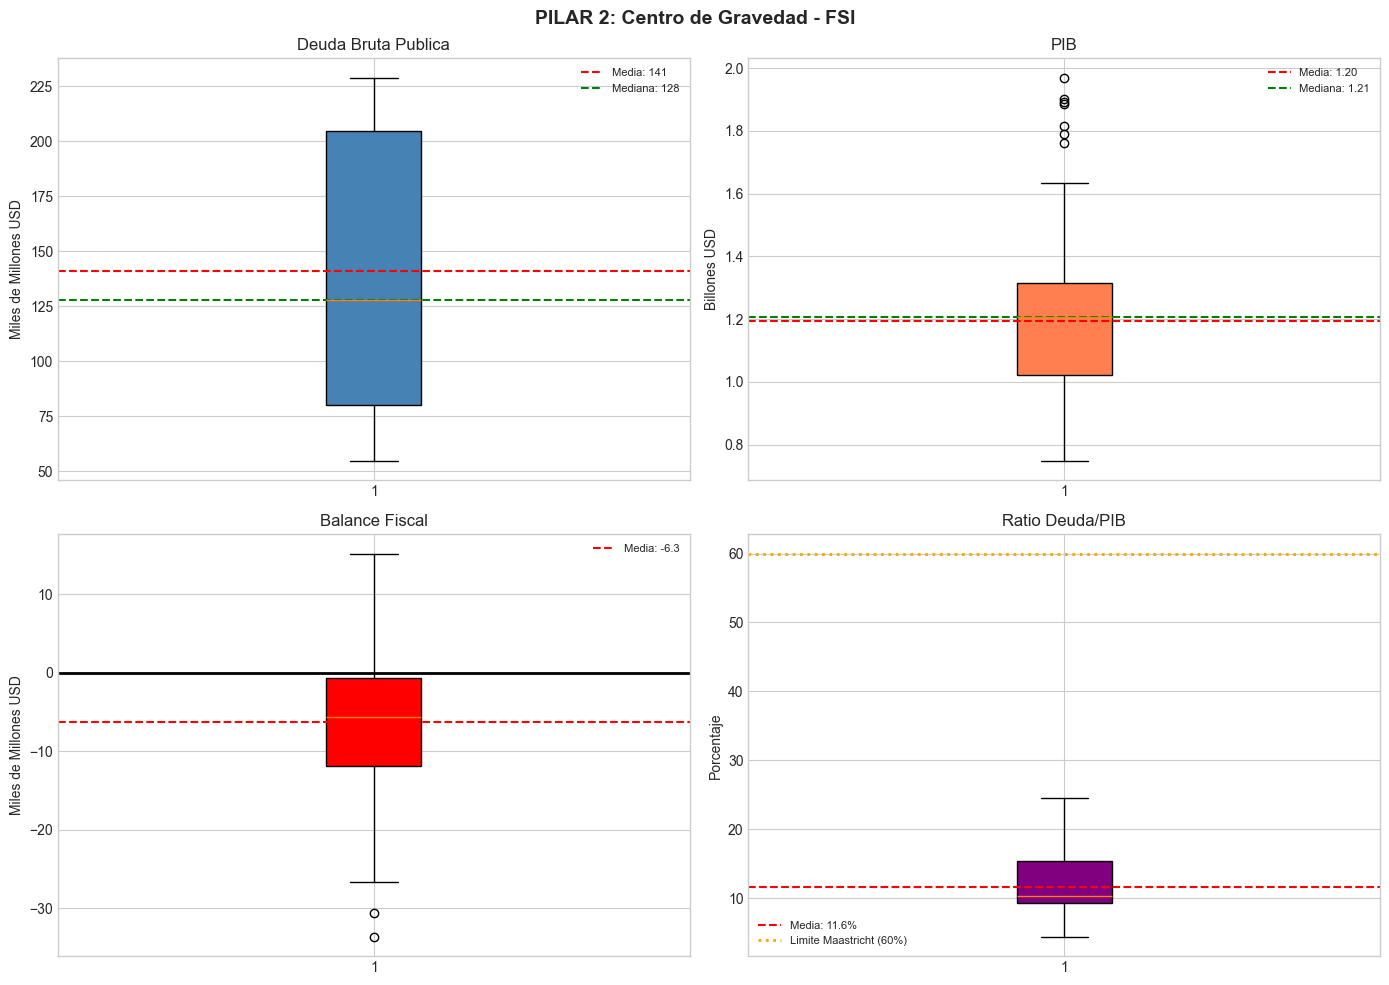

In [7]:
# Visualizacion del centro de gravedad
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('PILAR 2: Centro de Gravedad - FSI', fontsize=14, fontweight='bold')

# Grafico 1: Deuda Publica
if VAR_PRINCIPAL in df.columns:
    data = df[VAR_PRINCIPAL].dropna()
    bp = axes[0, 0].boxplot(data/1000, patch_artist=True)
    bp['boxes'][0].set_facecolor('steelblue')
    axes[0, 0].axhline(data.mean()/1000, color='red', linestyle='--', label=f'Media: {data.mean()/1000:,.0f}')
    axes[0, 0].axhline(data.median()/1000, color='green', linestyle='--', label=f'Mediana: {data.median()/1000:,.0f}')
    axes[0, 0].set_ylabel('Miles de Millones USD')
    axes[0, 0].set_title('Deuda Bruta Publica')
    axes[0, 0].legend(fontsize=8)

# Grafico 2: PIB
if 'PIB_USD_corriente' in df.columns:
    data = df['PIB_USD_corriente'].dropna()
    bp = axes[0, 1].boxplot(data/1e6, patch_artist=True)
    bp['boxes'][0].set_facecolor('coral')
    axes[0, 1].axhline(data.mean()/1e6, color='red', linestyle='--', label=f'Media: {data.mean()/1e6:,.2f}')
    axes[0, 1].axhline(data.median()/1e6, color='green', linestyle='--', label=f'Mediana: {data.median()/1e6:,.2f}')
    axes[0, 1].set_ylabel('Billones USD')
    axes[0, 1].set_title('PIB')
    axes[0, 1].legend(fontsize=8)

# Grafico 3: Balance Fiscal
if 'balance_mmxn_USD_corriente' in df.columns:
    data = df['balance_mmxn_USD_corriente'].dropna()
    bp = axes[1, 0].boxplot(data, patch_artist=True)
    bp['boxes'][0].set_facecolor('green' if data.mean() > 0 else 'red')
    axes[1, 0].axhline(0, color='black', linestyle='-', linewidth=2)
    axes[1, 0].axhline(data.mean(), color='red', linestyle='--', label=f'Media: {data.mean():,.1f}')
    axes[1, 0].set_ylabel('Miles de Millones USD')
    axes[1, 0].set_title('Balance Fiscal')
    axes[1, 0].legend(fontsize=8)

# Grafico 4: Ratio Deuda/PIB
if 'deuda_pib_ratio' in df.columns:
    data = df['deuda_pib_ratio'].dropna()
    bp = axes[1, 1].boxplot(data, patch_artist=True)
    bp['boxes'][0].set_facecolor('purple')
    axes[1, 1].axhline(data.mean(), color='red', linestyle='--', label=f'Media: {data.mean():.1f}%')
    axes[1, 1].axhline(60, color='orange', linestyle=':', linewidth=2, label='Limite Maastricht (60%)')
    axes[1, 1].set_ylabel('Porcentaje')
    axes[1, 1].set_title('Ratio Deuda/PIB')
    axes[1, 1].legend(fontsize=8)

plt.tight_layout()
plt.show()

---
## PILAR 3: Fiabilidad - ¿Que tan confiables son los datos?

**Objetivo:** Medir riesgo, volatilidad y detectar anomalias.

In [8]:
# ============================================================================
# PILAR 3: FIABILIDAD - RIESGO Y VOLATILIDAD
# ============================================================================

print("PILAR 3: MEDIDAS DE DISPERSION Y FIABILIDAD")
print("="*80)

# Calcular metricas de fiabilidad
stats_fiabilidad = []
for var in vars_visualizar:
    data = df[var].dropna()
    if len(data) > 0:
        # Coeficiente de variacion (CV)
        cv = (data.std() / abs(data.mean()) * 100) if data.mean() != 0 else np.nan
        
        # Deteccion de outliers (IQR)
        Q1, Q3 = data.quantile([0.25, 0.75])
        IQR = Q3 - Q1
        outliers = ((data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)).sum()
        
        # Volatilidad (cambio porcentual)
        cambio = data.pct_change().dropna() * 100
        
        stats_fiabilidad.append({
            'Variable': var.replace('_USD_corriente', '').replace('_musd', ''),
            'CV (%)': cv,
            'Cambio Prom (%)': cambio.mean(),
            'Volatilidad (%)': cambio.std(),
            'Outliers': outliers,
            '% Outliers': outliers / len(data) * 100
        })

df_fiabilidad = pd.DataFrame(stats_fiabilidad)
print(df_fiabilidad.to_string(index=False))

PILAR 3: MEDIDAS DE DISPERSION Y FIABILIDAD
           Variable     CV (%)  Cambio Prom (%)  Volatilidad (%)  Outliers  % Outliers
deuda_bruta_publica  43.422624         1.264711         6.300721         0    0.000000
                PIB  23.016071         1.100000         6.652474         7    7.608696
       balance_mmxn 133.942948      -119.474246      1157.011882         2    2.173913
  inflacion_yoy_eoq  28.821103         1.194028        16.567830         5    5.434783
    CuentaCorriente 190.130923      -328.543627      2747.334489         5    5.434783
           tcn_mean  25.890254         0.991716         5.065613         0    0.000000


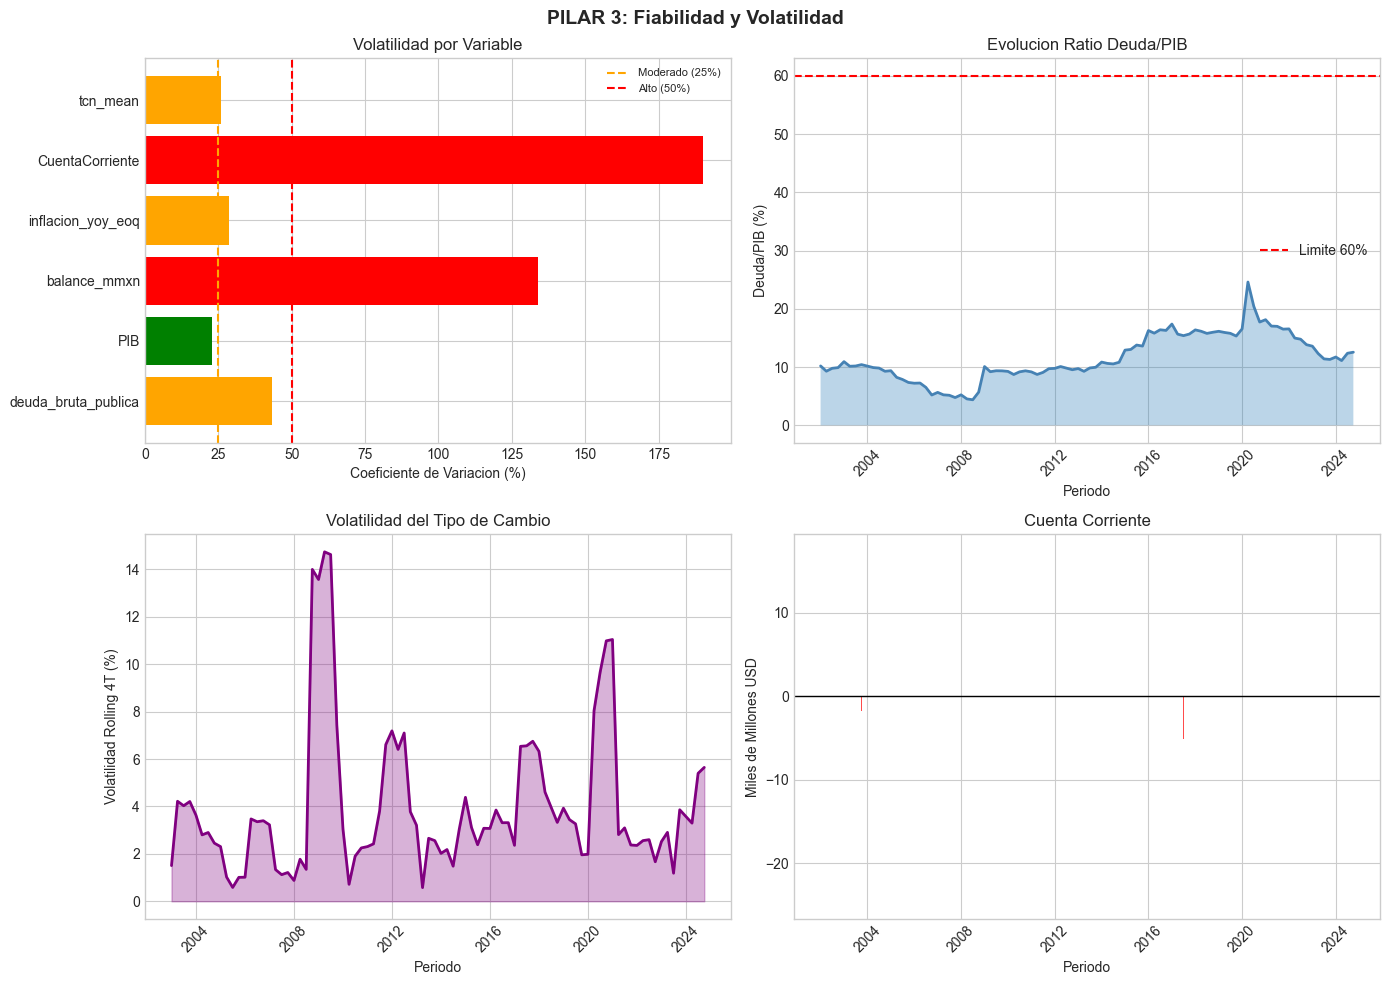

In [9]:
# Visualizacion de volatilidad
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('PILAR 3: Fiabilidad y Volatilidad', fontsize=14, fontweight='bold')

# Grafico 1: CV por variable
colors = ['red' if cv > 50 else 'orange' if cv > 25 else 'green' for cv in df_fiabilidad['CV (%)']]
axes[0, 0].barh(df_fiabilidad['Variable'], df_fiabilidad['CV (%)'], color=colors)
axes[0, 0].axvline(25, color='orange', linestyle='--', label='Moderado (25%)')
axes[0, 0].axvline(50, color='red', linestyle='--', label='Alto (50%)')
axes[0, 0].set_xlabel('Coeficiente de Variacion (%)')
axes[0, 0].set_title('Volatilidad por Variable')
axes[0, 0].legend(fontsize=8)

# Grafico 2: Evolucion Deuda/PIB
if 'deuda_pib_ratio' in df.columns:
    axes[0, 1].plot(df['periodo'], df['deuda_pib_ratio'], color='steelblue', linewidth=2)
    axes[0, 1].fill_between(df['periodo'], df['deuda_pib_ratio'], alpha=0.3)
    axes[0, 1].axhline(60, color='red', linestyle='--', label='Limite 60%')
    axes[0, 1].set_xlabel('Periodo')
    axes[0, 1].set_ylabel('Deuda/PIB (%)')
    axes[0, 1].set_title('Evolucion Ratio Deuda/PIB')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].legend()

# Grafico 3: Rolling volatilidad del TCN
if 'tcn_mean' in df.columns:
    tcn_vol = df['tcn_mean'].pct_change().rolling(4).std() * 100
    axes[1, 0].plot(df['periodo'], tcn_vol, color='purple', linewidth=2)
    axes[1, 0].fill_between(df['periodo'], tcn_vol, alpha=0.3, color='purple')
    axes[1, 0].set_xlabel('Periodo')
    axes[1, 0].set_ylabel('Volatilidad Rolling 4T (%)')
    axes[1, 0].set_title('Volatilidad del Tipo de Cambio')
    axes[1, 0].tick_params(axis='x', rotation=45)

# Grafico 4: Cuenta Corriente
if 'CuentaCorriente' in df.columns:
    cc = df['CuentaCorriente']
    colors_cc = ['green' if x > 0 else 'red' for x in cc]
    axes[1, 1].bar(df['periodo'], cc/1000, color=colors_cc, alpha=0.7)
    axes[1, 1].axhline(0, color='black', linewidth=1)
    axes[1, 1].set_xlabel('Periodo')
    axes[1, 1].set_ylabel('Miles de Millones USD')
    axes[1, 1].set_title('Cuenta Corriente')
    axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---
## PILAR 4: Margen de Error - Intervalos de Confianza

**Objetivo:** Proporcionar rangos probables con certeza estadistica.

In [10]:
# ============================================================================
# PILAR 4: MARGEN DE ERROR - INTERVALOS DE CONFIANZA
# ============================================================================

print("PILAR 4: INTERVALOS DE CONFIANZA (95%)")
print("="*80)

def intervalo_confianza(data, confianza=0.95):
    """Calcula intervalo de confianza para la media."""
    n = len(data)
    media = data.mean()
    sem = stats.sem(data)
    h = sem * stats.t.ppf((1 + confianza) / 2, n - 1)
    return media - h, media + h, h

# Calcular IC para variables principales
ic_results = []
for var in vars_visualizar:
    data = df[var].dropna()
    if len(data) >= 10:
        ic_low, ic_high, margen = intervalo_confianza(data)
        ic_results.append({
            'Variable': var.replace('_USD_corriente', '').replace('_musd', ''),
            'Media': data.mean(),
            'IC 95% Inferior': ic_low,
            'IC 95% Superior': ic_high,
            'Margen (%)': abs(margen / data.mean() * 100) if data.mean() != 0 else 0
        })

df_ic = pd.DataFrame(ic_results)
print(df_ic.to_string(index=False))

PILAR 4: INTERVALOS DE CONFIANZA (95%)
           Variable         Media  IC 95% Inferior  IC 95% Superior  Margen (%)
deuda_bruta_publica  1.410264e+05     1.283445e+05     1.537083e+05    8.992571
                PIB  1.195386e+06     1.138408e+06     1.252364e+06    4.766493
       balance_mmxn -6.323902e+00    -8.078076e+00    -4.569728e+00   27.738799
  inflacion_yoy_eoq  4.476304e+00     4.209128e+00     4.743481e+00    5.968681
    CuentaCorriente -3.092619e+03    -4.310338e+03    -1.874900e+03   39.374999
           tcn_mean  1.492747e+01     1.412710e+01     1.572784e+01    5.361720


---
## PILAR 5: Pruebas de Hipotesis - ¿Fue suerte o fue real?

**Objetivo:** Validar afirmaciones con evidencia estadistica usando Chi-Cuadrada.

In [11]:
# ============================================================================
# PILAR 5: PRUEBAS DE HIPOTESIS - CHI-CUADRADA
# ============================================================================

print("PILAR 5: PRUEBAS DE HIPOTESIS")
print("="*80)

# Hipotesis 1: ¿El nivel de deuda es independiente del trimestre?
print("\n--- HIPOTESIS 1: Independencia Nivel Deuda vs Trimestre ---")
print("H0: El nivel de deuda es independiente del trimestre")
print("H1: El nivel de deuda depende del trimestre")

df_test = df.copy()
df_test['deuda_cat'] = pd.qcut(df_test[VAR_PRINCIPAL].dropna(), q=3, labels=['Baja', 'Media', 'Alta'])

contingencia = pd.crosstab(df_test['deuda_cat'].dropna(), df_test.loc[df_test['deuda_cat'].notna(), 'TRIMESTRE'])
print("\nTabla de Contingencia:")
print(contingencia)

if contingencia.shape[0] > 1 and contingencia.shape[1] > 1:
    chi2, p_value, dof, expected = chi2_contingency(contingencia)
    print(f"\nEstadistico Chi-cuadrada: {chi2:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Conclusion: {'RECHAZAR H0' if p_value < 0.05 else 'NO RECHAZAR H0'} (alfa=0.05)")
else:
    chi2, p_value = 0, 1.0
    print("Datos insuficientes")

PILAR 5: PRUEBAS DE HIPOTESIS

--- HIPOTESIS 1: Independencia Nivel Deuda vs Trimestre ---
H0: El nivel de deuda es independiente del trimestre
H1: El nivel de deuda depende del trimestre

Tabla de Contingencia:
TRIMESTRE  1  2  3  4
deuda_cat            
Baja       8  8  8  7
Media      8  7  7  8
Alta       7  8  8  8

Estadistico Chi-cuadrada: 0.3269
p-value: 0.9994
Conclusion: NO RECHAZAR H0 (alfa=0.05)


In [12]:
# Hipotesis 2: ¿El balance fiscal cambio antes/despues de 2015?
print("\n--- HIPOTESIS 2: Cambio estructural 2015 ---")
print("H0: El balance fiscal es independiente del periodo (pre/post 2015)")
print("H1: El balance fiscal depende del periodo")

if 'balance_mmxn_USD_corriente' in df.columns:
    df_test['era'] = df_test['periodo'].apply(lambda x: 'Pre-2015' if x.year < 2015 else 'Post-2015')
    df_test['balance_signo'] = df_test['balance_mmxn_USD_corriente'].apply(lambda x: 'Superavit' if x > 0 else 'Deficit')
    
    contingencia2 = pd.crosstab(df_test['balance_signo'], df_test['era'])
    print("\nTabla de Contingencia:")
    print(contingencia2)
    
    if contingencia2.shape[0] > 1 and contingencia2.shape[1] > 1:
        chi2_2, p_value_2, dof_2, expected_2 = chi2_contingency(contingencia2)
        print(f"\nEstadistico Chi-cuadrada: {chi2_2:.4f}")
        print(f"p-value: {p_value_2:.4f}")
        print(f"Conclusion: {'RECHAZAR H0' if p_value_2 < 0.05 else 'NO RECHAZAR H0'}")
    else:
        p_value_2 = 1.0
else:
    p_value_2 = 1.0
    print("Variable no disponible")


--- HIPOTESIS 2: Cambio estructural 2015 ---
H0: El balance fiscal es independiente del periodo (pre/post 2015)
H1: El balance fiscal depende del periodo

Tabla de Contingencia:
era            Post-2015  Pre-2015
balance_signo                     
Deficit               38        32
Superavit              2        20

Estadistico Chi-cuadrada: 12.1347
p-value: 0.0005
Conclusion: RECHAZAR H0


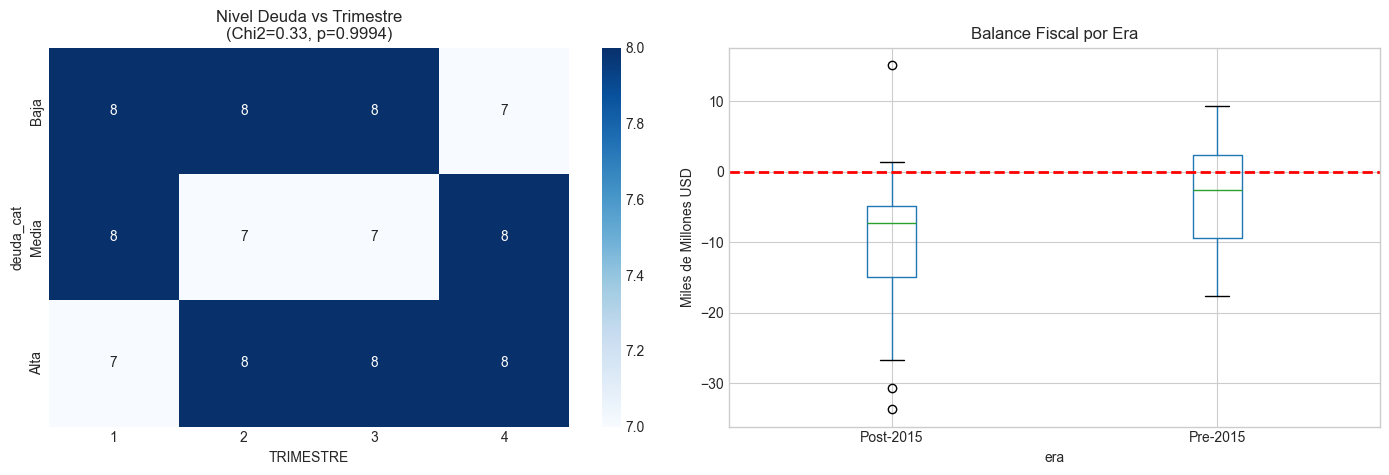

In [13]:
# Visualizacion
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 5: Pruebas de Hipotesis - Chi-Cuadrada', fontsize=14, fontweight='bold')

# Grafico 1: Heatmap de contingencia
if contingencia.shape[0] > 1 and contingencia.shape[1] > 1:
    sns.heatmap(contingencia, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Nivel Deuda vs Trimestre\n(Chi2={chi2:.2f}, p={p_value:.4f})')

# Grafico 2: Balance por era
if 'balance_mmxn_USD_corriente' in df.columns:
    df_test.boxplot(column='balance_mmxn_USD_corriente', by='era', ax=axes[1])
    axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[1].set_title('Balance Fiscal por Era')
    axes[1].set_ylabel('Miles de Millones USD')
    plt.suptitle('')

plt.tight_layout()
plt.show()

---
## PILAR 6: Regresion/Prediccion - ¿Como predecir el futuro?

**Objetivo:** Modelar relaciones para anticipar resultados usando Machine Learning.

In [14]:
# ============================================================================
# PILAR 6: PREDICCION CON MACHINE LEARNING
# ============================================================================

print("PILAR 6: MODELOS DE PREDICCION - MACHINE LEARNING")
print("="*80)

# Objetivo: Predecir Deuda/PIB ratio usando variables macroeconomicas
df_ml = df.copy()
df_ml['year'] = df_ml['periodo'].dt.year

# Features potenciales
features_potenciales = ['PIB_USD_corriente', 'balance_mmxn_USD_corriente', 'inflacion_yoy_eoq', 
                        'TasaMXN', 'tcn_mean', 'CuentaCorriente', 'TRIMESTRE', 'year']
features = [f for f in features_potenciales if f in df_ml.columns]

target = VAR_PRINCIPAL

print(f"Features para modelo: {features}")
print(f"Target: {target}")

# Preparar dataset
df_ml = df_ml[features + [target]].dropna()
X = df_ml[features]
y = df_ml[target]

print(f"\nDatos para entrenamiento: {len(df_ml)} observaciones")

if len(df_ml) >= 20:
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Escalar features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

PILAR 6: MODELOS DE PREDICCION - MACHINE LEARNING
Features para modelo: ['PIB_USD_corriente', 'balance_mmxn_USD_corriente', 'inflacion_yoy_eoq', 'TasaMXN', 'tcn_mean', 'CuentaCorriente', 'TRIMESTRE', 'year']
Target: deuda_bruta_publica_musd

Datos para entrenamiento: 68 observaciones


In [15]:
# Entrenar multiples modelos
if len(df_ml) >= 20:
    modelos = {
        'Regresion Lineal': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    resultados = []
    predicciones = {}
    
    for nombre, modelo in modelos.items():
        if 'Forest' in nombre or 'Boosting' in nombre:
            modelo.fit(X_train, y_train)
            y_pred = modelo.predict(X_test)
        else:
            modelo.fit(X_train_scaled, y_train)
            y_pred = modelo.predict(X_test_scaled)
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        resultados.append({
            'Modelo': nombre,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'MAPE (%)': (mae / y_test.mean() * 100)
        })
        predicciones[nombre] = y_pred
    
    df_resultados = pd.DataFrame(resultados).sort_values('R2', ascending=False)
    print("\nCOMPARACION DE MODELOS:")
    print(df_resultados.to_string(index=False))
    
    mejor_modelo = df_resultados.iloc[0]['Modelo']
    print(f"\n*** MEJOR MODELO: {mejor_modelo} (R2 = {df_resultados.iloc[0]['R2']:.4f}) ***")
else:
    print("Datos insuficientes para entrenamiento")
    mejor_modelo = "N/A"
    df_resultados = pd.DataFrame()


COMPARACION DE MODELOS:
           Modelo        RMSE         MAE       R2  MAPE (%)
 Regresion Lineal 5415.303415 4618.901911 0.990791  3.032881
    Random Forest 5486.169020 3875.725800 0.990548  2.544894
            Ridge 5578.715924 4904.876764 0.990227  3.220659
Gradient Boosting 5581.966034 4232.654858 0.990215  2.779262

*** MEJOR MODELO: Regresion Lineal (R2 = 0.9908) ***


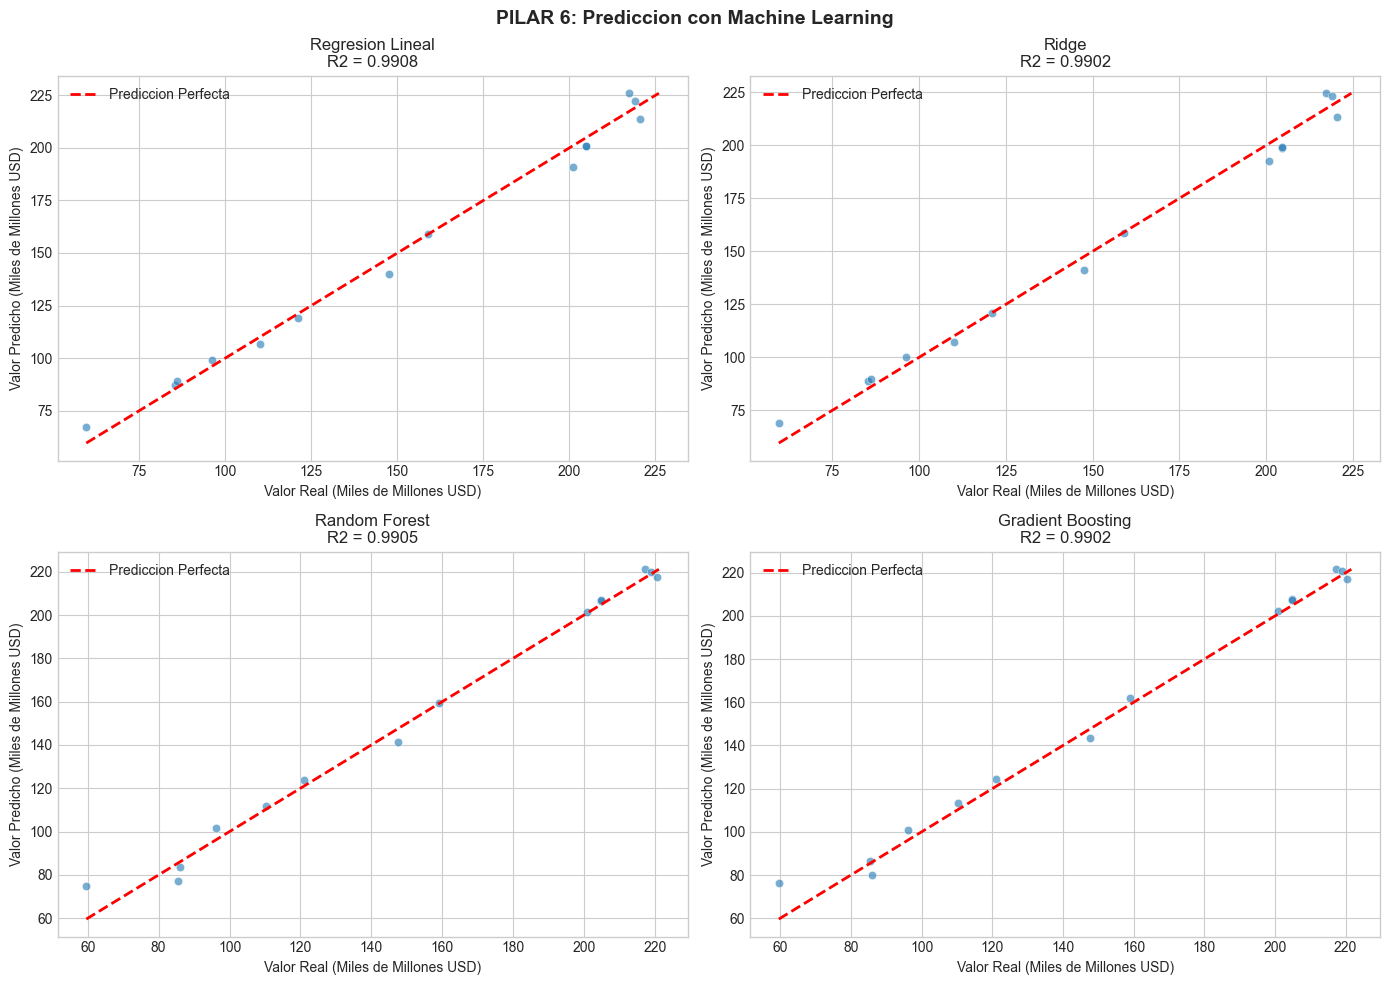

In [16]:
# Visualizacion de predicciones
if len(df_ml) >= 20 and len(predicciones) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('PILAR 6: Prediccion con Machine Learning', fontsize=14, fontweight='bold')
    
    for idx, (nombre, y_pred) in enumerate(predicciones.items()):
        ax = axes[idx // 2, idx % 2]
        ax.scatter(y_test/1000, y_pred/1000, alpha=0.6, edgecolors='white', linewidth=0.5)
        
        min_val = min(y_test.min(), y_pred.min())/1000
        max_val = max(y_test.max(), y_pred.max())/1000
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Prediccion Perfecta')
        
        r2 = r2_score(y_test, y_pred)
        ax.set_xlabel('Valor Real (Miles de Millones USD)')
        ax.set_ylabel('Valor Predicho (Miles de Millones USD)')
        ax.set_title(f'{nombre}\nR2 = {r2:.4f}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()


IMPORTANCIA DE VARIABLES (Random Forest):
                   Feature  Importancia
                      year     0.519125
                  tcn_mean     0.413956
                   TasaMXN     0.031362
         inflacion_yoy_eoq     0.021847
         PIB_USD_corriente     0.009447
           CuentaCorriente     0.002691
balance_mmxn_USD_corriente     0.001099
                 TRIMESTRE     0.000473


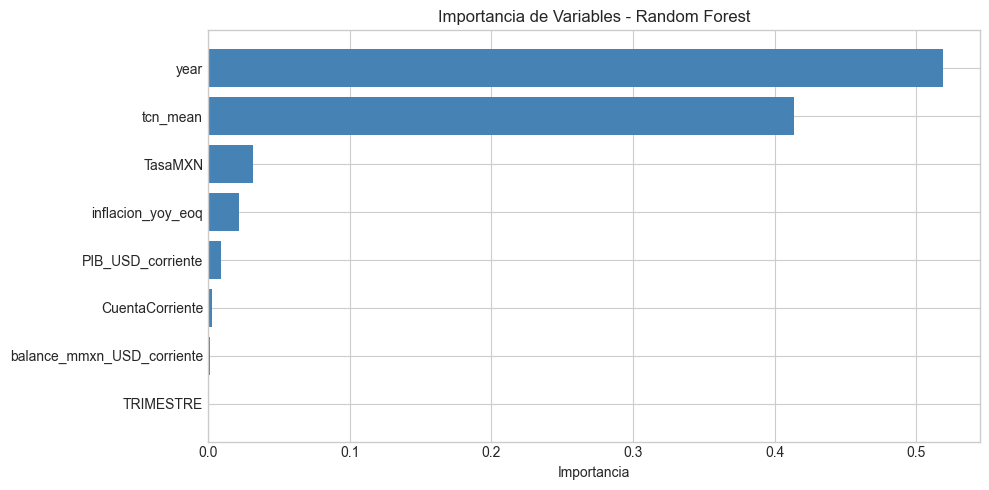

In [17]:
# Importancia de features
if len(df_ml) >= 20 and 'Random Forest' in modelos:
    rf_model = modelos['Random Forest']
    importancia = pd.DataFrame({
        'Feature': features,
        'Importancia': rf_model.feature_importances_
    }).sort_values('Importancia', ascending=False)
    
    print("\nIMPORTANCIA DE VARIABLES (Random Forest):")
    print(importancia.to_string(index=False))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.barh(importancia['Feature'], importancia['Importancia'], color='steelblue')
    ax.set_xlabel('Importancia')
    ax.set_title('Importancia de Variables - Random Forest')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

---
## PILAR 7: Series de Tiempo - ¿Que patrones se repiten?

**Objetivo:** Detectar tendencias y estacionalidad para pronosticos precisos.

In [18]:
# ============================================================================
# PILAR 7: SERIES DE TIEMPO
# ============================================================================

print("PILAR 7: ANALISIS DE SERIES DE TIEMPO")
print("="*80)

# Preparar serie temporal
ts_data = df.set_index('periodo')[VAR_PRINCIPAL].dropna()
ts_data = ts_data.asfreq('QS')

print(f"Serie temporal: {VAR_PRINCIPAL}")
print(f"Periodo: {ts_data.index.min()} a {ts_data.index.max()}")
print(f"Observaciones: {len(ts_data)}")

# Test de estacionariedad
if len(ts_data.dropna()) >= 10:
    adf_result = adfuller(ts_data.dropna())
    print(f"\nTest Dickey-Fuller Aumentado:")
    print(f"  Estadistico ADF: {adf_result[0]:.4f}")
    print(f"  p-value: {adf_result[1]:.4f}")
    print(f"  Conclusion: {'ESTACIONARIA' if adf_result[1] < 0.05 else 'NO ESTACIONARIA'}")
else:
    adf_result = [0, 1.0]
    print("Datos insuficientes para test ADF")

PILAR 7: ANALISIS DE SERIES DE TIEMPO
Serie temporal: deuda_bruta_publica_musd
Periodo: 2002-01-01 00:00:00 a 2024-10-01 00:00:00
Observaciones: 92

Test Dickey-Fuller Aumentado:
  Estadistico ADF: -0.4060
  p-value: 0.9091
  Conclusion: NO ESTACIONARIA


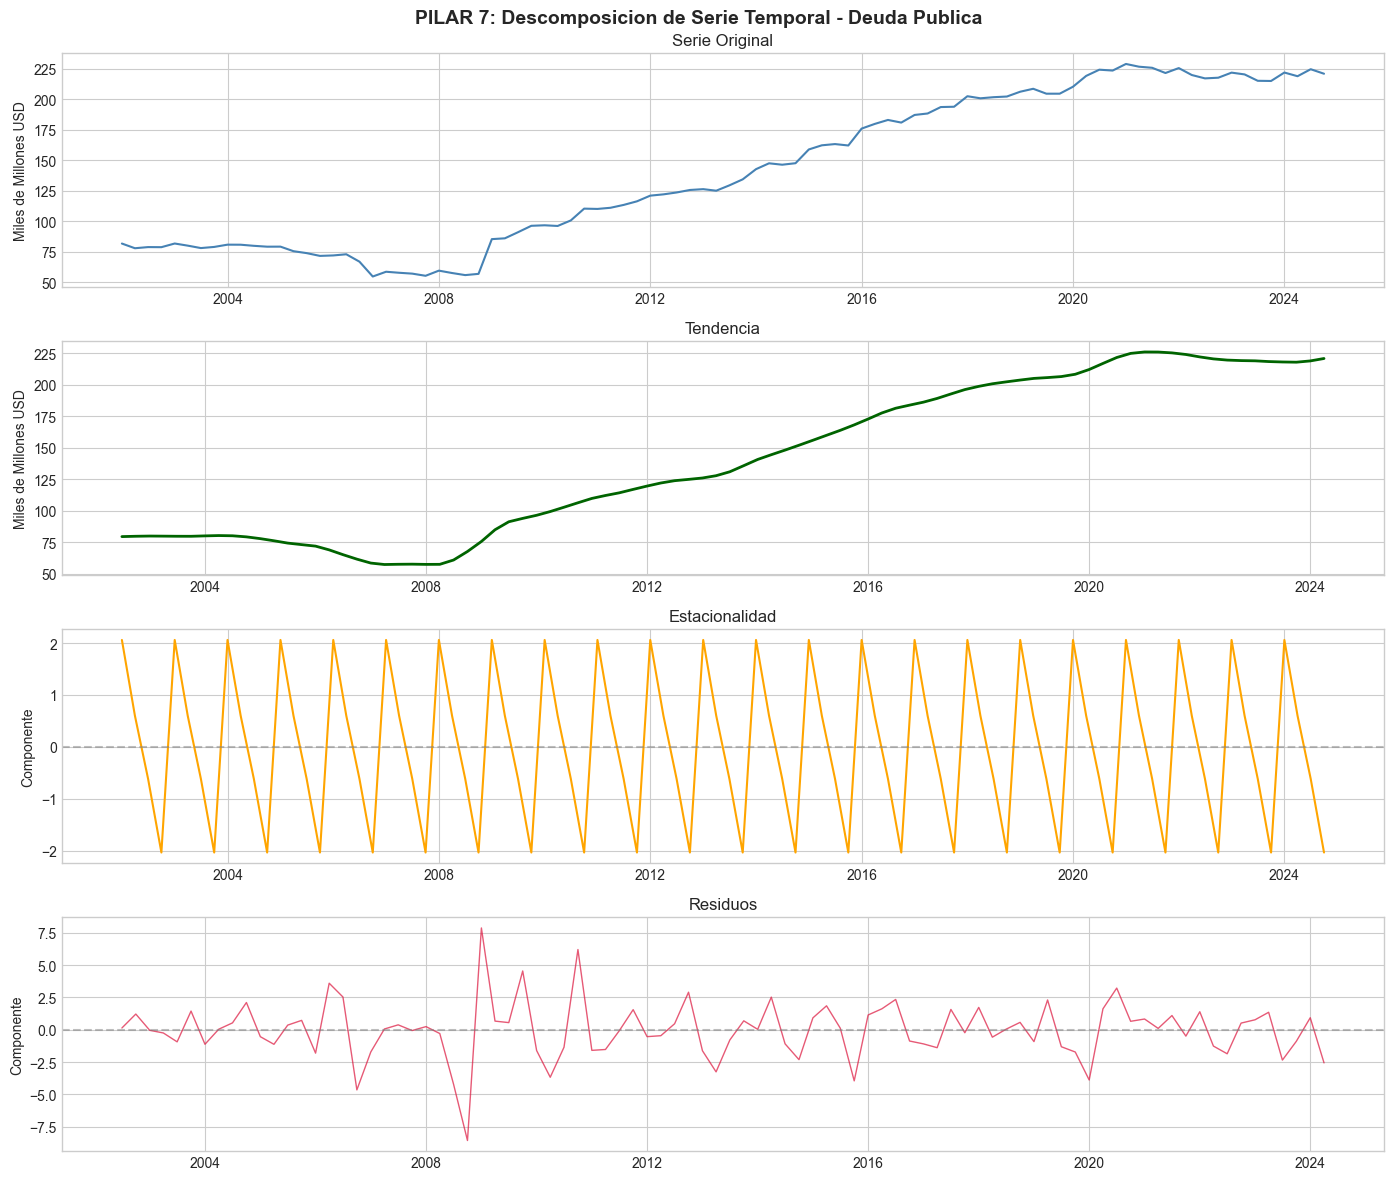

In [19]:
# Descomposicion de la serie
if len(ts_data.dropna()) >= 8:
    decomposition = seasonal_decompose(ts_data.dropna(), model='additive', period=4)
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    fig.suptitle('PILAR 7: Descomposicion de Serie Temporal - Deuda Publica', fontsize=14, fontweight='bold')
    
    axes[0].plot(ts_data/1000, color='steelblue', linewidth=1.5)
    axes[0].set_title('Serie Original')
    axes[0].set_ylabel('Miles de Millones USD')
    
    axes[1].plot(decomposition.trend/1000, color='darkgreen', linewidth=2)
    axes[1].set_title('Tendencia')
    axes[1].set_ylabel('Miles de Millones USD')
    
    axes[2].plot(decomposition.seasonal/1000, color='orange', linewidth=1.5)
    axes[2].set_title('Estacionalidad')
    axes[2].set_ylabel('Componente')
    axes[2].axhline(0, color='gray', linestyle='--', alpha=0.5)
    
    axes[3].plot(decomposition.resid/1000, color='crimson', linewidth=1, alpha=0.7)
    axes[3].set_title('Residuos')
    axes[3].set_ylabel('Componente')
    axes[3].axhline(0, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

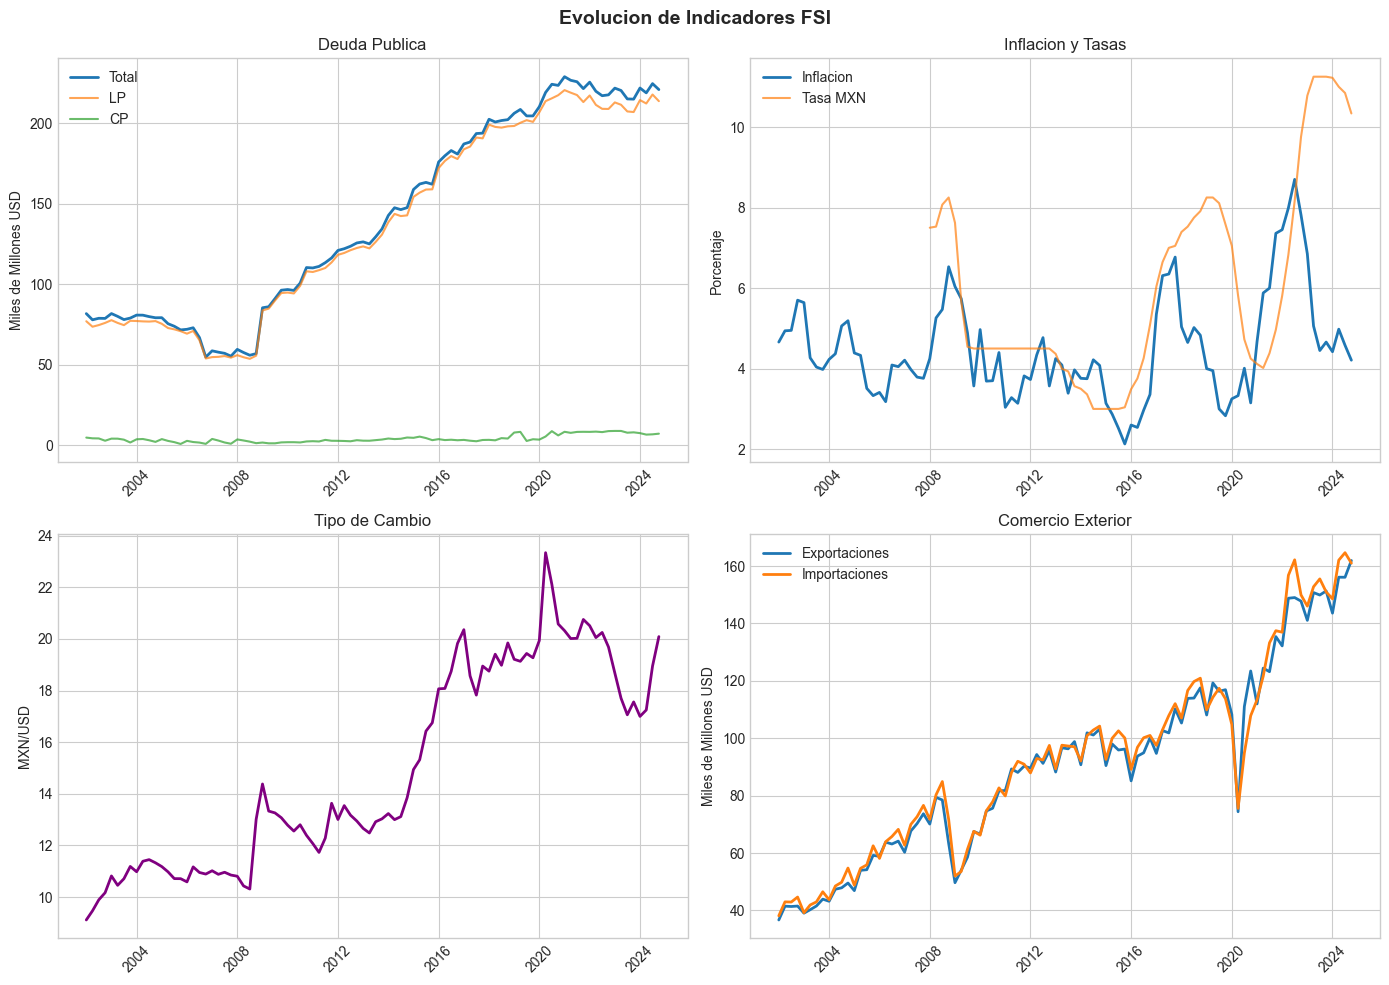

In [20]:
# Evolucion de multiples indicadores FSI
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Evolucion de Indicadores FSI', fontsize=14, fontweight='bold')

# Deuda
axes[0, 0].plot(df['periodo'], df[VAR_PRINCIPAL]/1000, label='Total', linewidth=2)
if 'deuda_publica_lp_musd' in df.columns:
    axes[0, 0].plot(df['periodo'], df['deuda_publica_lp_musd']/1000, label='LP', linewidth=1.5, alpha=0.7)
if 'deuda_publica_cp_musd' in df.columns:
    axes[0, 0].plot(df['periodo'], df['deuda_publica_cp_musd']/1000, label='CP', linewidth=1.5, alpha=0.7)
axes[0, 0].set_ylabel('Miles de Millones USD')
axes[0, 0].set_title('Deuda Publica')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# Inflacion y Tasas
if 'inflacion_yoy_eoq' in df.columns:
    axes[0, 1].plot(df['periodo'], df['inflacion_yoy_eoq'], label='Inflacion', linewidth=2)
if 'TasaMXN' in df.columns:
    axes[0, 1].plot(df['periodo'], df['TasaMXN'], label='Tasa MXN', linewidth=1.5, alpha=0.7)
axes[0, 1].set_ylabel('Porcentaje')
axes[0, 1].set_title('Inflacion y Tasas')
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=45)

# Tipo de Cambio
if 'tcn_mean' in df.columns:
    axes[1, 0].plot(df['periodo'], df['tcn_mean'], color='purple', linewidth=2)
    axes[1, 0].set_ylabel('MXN/USD')
    axes[1, 0].set_title('Tipo de Cambio')
    axes[1, 0].tick_params(axis='x', rotation=45)

# Sector Externo
if 'Exportaciones' in df.columns and 'Importaciones' in df.columns:
    axes[1, 1].plot(df['periodo'], df['Exportaciones']/1000, label='Exportaciones', linewidth=2)
    axes[1, 1].plot(df['periodo'], df['Importaciones']/1000, label='Importaciones', linewidth=2)
    axes[1, 1].set_ylabel('Miles de Millones USD')
    axes[1, 1].set_title('Comercio Exterior')
    axes[1, 1].legend()
    axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---
## PILAR 8: ANOVA - ¿Que estrategia es mejor?

**Objetivo:** Comparar rendimiento entre grupos objetivamente.

In [21]:
# ============================================================================
# PILAR 8: ANOVA - COMPARACION ENTRE GRUPOS
# ============================================================================

print("PILAR 8: ANALISIS DE VARIANZA (ANOVA)")
print("="*80)

# Analisis 1: Comparar Deuda/PIB por trimestre
print("\n--- ANOVA 1: Ratio Deuda/PIB por Trimestre ---")

if 'deuda_pib_ratio' in df.columns:
    grupos_trim = [df[df['TRIMESTRE'] == t]['deuda_pib_ratio'].dropna() for t in [1, 2, 3, 4]]
    grupos_trim = [g for g in grupos_trim if len(g) >= 3]
    
    if len(grupos_trim) >= 2:
        f_stat, p_anova = stats.f_oneway(*grupos_trim)
        print(f"Estadistico F: {f_stat:.4f}")
        print(f"p-value: {p_anova:.4f}")
        print(f"Conclusion: {'RECHAZAR H0' if p_anova < 0.05 else 'NO RECHAZAR H0'}")
    else:
        f_stat, p_anova = 0, 1.0
        print("Datos insuficientes")
else:
    f_stat, p_anova = 0, 1.0
    print("Variable no disponible")

PILAR 8: ANALISIS DE VARIANZA (ANOVA)

--- ANOVA 1: Ratio Deuda/PIB por Trimestre ---
Estadistico F: 0.0809
p-value: 0.9703
Conclusion: NO RECHAZAR H0


In [22]:
# Analisis 2: Comparar indicadores por decada
print("\n--- ANOVA 2: Deuda por Decada ---")

df['decada'] = (df['periodo'].dt.year // 10) * 10
decadas = df['decada'].unique()
grupos_decada = [df[df['decada'] == d][VAR_PRINCIPAL].dropna() for d in sorted(decadas)]
grupos_decada = [g for g in grupos_decada if len(g) >= 3]

if len(grupos_decada) >= 2:
    f_stat2, p_anova2 = stats.f_oneway(*grupos_decada)
    print(f"Estadistico F: {f_stat2:.4f}")
    print(f"p-value: {p_anova2:.6f}")
    print(f"Conclusion: {'RECHAZAR H0' if p_anova2 < 0.05 else 'NO RECHAZAR H0'}")
else:
    f_stat2, p_anova2 = 0, 1.0
    print("Datos insuficientes")


--- ANOVA 2: Deuda por Decada ---
Estadistico F: 218.2033
p-value: 0.000000
Conclusion: RECHAZAR H0


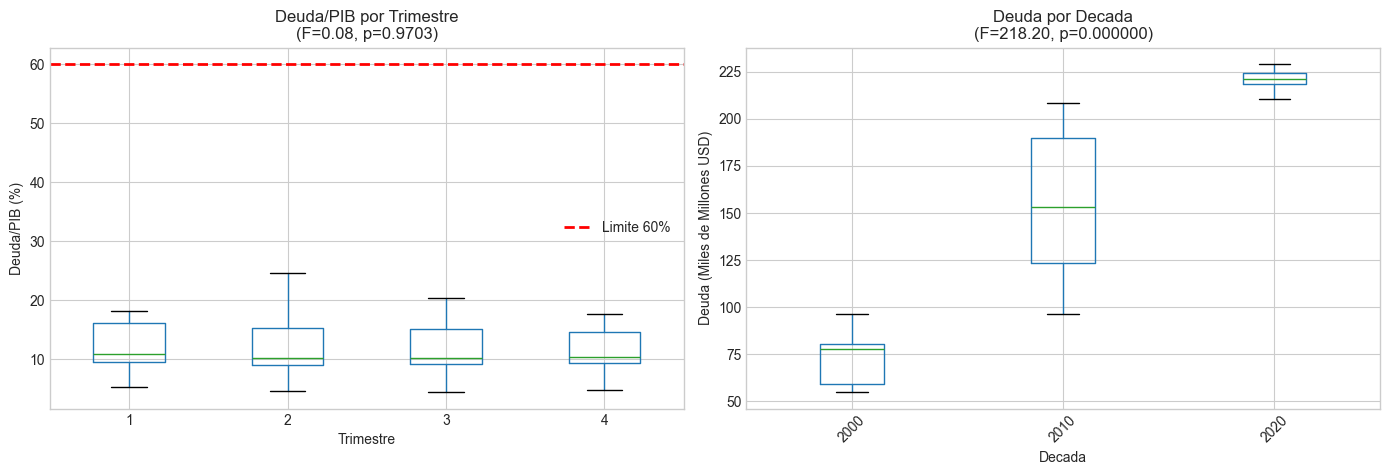

In [23]:
# Visualizacion ANOVA
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('PILAR 8: ANOVA - Comparacion entre Grupos', fontsize=14, fontweight='bold')

# Grafico 1: Deuda/PIB por trimestre
if 'deuda_pib_ratio' in df.columns:
    df.boxplot(column='deuda_pib_ratio', by='TRIMESTRE', ax=axes[0])
    axes[0].axhline(60, color='red', linestyle='--', linewidth=2, label='Limite 60%')
    axes[0].set_title(f'Deuda/PIB por Trimestre\n(F={f_stat:.2f}, p={p_anova:.4f})')
    axes[0].set_xlabel('Trimestre')
    axes[0].set_ylabel('Deuda/PIB (%)')
    axes[0].legend()
    plt.suptitle('')

# Grafico 2: Deuda por decada
df_plot = df.copy()
df_plot[VAR_PRINCIPAL] = df_plot[VAR_PRINCIPAL] / 1000
df_plot.boxplot(column=VAR_PRINCIPAL, by='decada', ax=axes[1])
axes[1].set_title(f'Deuda por Decada\n(F={f_stat2:.2f}, p={p_anova2:.6f})')
axes[1].set_xlabel('Decada')
axes[1].set_ylabel('Deuda (Miles de Millones USD)')
axes[1].tick_params(axis='x', rotation=45)
plt.suptitle('')

plt.tight_layout()
plt.show()

In [24]:
# Estadisticas descriptivas
print("\nESTADISTICAS POR TRIMESTRE:")
if 'deuda_pib_ratio' in df.columns:
    print(df.groupby('TRIMESTRE')['deuda_pib_ratio'].agg(['count', 'mean', 'std', 'min', 'max']).round(2))

print("\nESTADISTICAS DE DEUDA POR DECADA (Miles de Millones USD):")
stats_decada = df.groupby('decada')[VAR_PRINCIPAL].agg(['count', 'mean', 'std', 'min', 'max'])
stats_decada[['mean', 'std', 'min', 'max']] = stats_decada[['mean', 'std', 'min', 'max']] / 1000
print(stats_decada.round(2))


ESTADISTICAS POR TRIMESTRE:
           count   mean   std   min    max
TRIMESTRE                                 
1             23  11.89  3.81  5.24  18.14
2             23  11.65  4.51  4.54  24.60
3             23  11.51  4.05  4.39  20.44
4             23  11.32  3.77  4.77  17.73

ESTADISTICAS DE DEUDA POR DECADA (Miles de Millones USD):
        count    mean    std     min     max
decada                                      
2000       32   73.20  11.57   54.77   96.35
2010       40  155.26  36.96   96.22  208.71
2020       20  221.07   4.54  210.40  229.06


---
## RESUMEN EJECUTIVO

Sintesis de los hallazgos de los 8 pilares estadisticos para FSI.

In [25]:
# ============================================================================
# RESUMEN EJECUTIVO
# ============================================================================

print("="*80)
print("RESUMEN EJECUTIVO: 8 PILARES ESTADISTICOS - FSI (Dataset Final)")
print("="*80)

print("\n1. DISTRIBUCIONES:")
for var in vars_visualizar[:4]:
    data = df[var].dropna()
    if len(data) >= 20:
        _, p = shapiro(data) if len(data) < 5000 else normaltest(data)
        print(f"   - {var.replace('_USD_corriente', '').replace('_musd', '')[:30]}: {'Normal' if p > 0.05 else 'No Normal'} (p={p:.4f})")

print("\n2. CENTRO DE GRAVEDAD:")
print(f"   - Deuda Bruta Promedio: {df[VAR_PRINCIPAL].mean()/1000:,.1f} miles de millones USD")
if 'deuda_pib_ratio' in df.columns:
    print(f"   - Ratio Deuda/PIB Promedio: {df['deuda_pib_ratio'].mean():.1f}%")

print("\n3. FIABILIDAD:")
cv_deuda = df[VAR_PRINCIPAL].std() / df[VAR_PRINCIPAL].mean() * 100
print(f"   - CV Deuda: {cv_deuda:.1f}%")
if 'tcn_mean' in df.columns:
    cv_tcn = df['tcn_mean'].std() / df['tcn_mean'].mean() * 100
    print(f"   - CV Tipo de Cambio: {cv_tcn:.1f}%")

print("\n4. MARGEN DE ERROR:")
ic_low, ic_high, margen = intervalo_confianza(df[VAR_PRINCIPAL].dropna())
print(f"   - IC 95% Deuda: [{ic_low/1000:,.1f}, {ic_high/1000:,.1f}] miles de millones USD")

print("\n5. PRUEBAS DE HIPOTESIS (Chi-Cuadrada):")
print(f"   - Nivel deuda vs Trimestre: {'Dependientes' if p_value < 0.05 else 'Independientes'} (p={p_value:.4f})")

print("\n6. PREDICCION (Machine Learning):")
if len(df_resultados) > 0:
    print(f"   - Mejor modelo: {mejor_modelo}")
    print(f"   - R2 = {df_resultados.iloc[0]['R2']:.4f}")
else:
    print("   - No disponible")

print("\n7. SERIES DE TIEMPO:")
print(f"   - Serie Deuda: {'ESTACIONARIA' if adf_result[1] < 0.05 else 'NO ESTACIONARIA'}")
tendencia = 'CRECIENTE' if df[VAR_PRINCIPAL].iloc[-1] > df[VAR_PRINCIPAL].iloc[0] else 'DECRECIENTE'
print(f"   - Tendencia: {tendencia}")

print("\n8. ANOVA:")
print(f"   - Diferencia entre trimestres: {'SI' if p_anova < 0.05 else 'NO'} (p={p_anova:.4f})")
print(f"   - Diferencia entre decadas: {'SI' if p_anova2 < 0.05 else 'NO'} (p={p_anova2:.6f})")

print("\n" + "="*80)
print("INDICADORES DE SOSTENIBILIDAD FINANCIERA")
print("="*80)
if 'deuda_pib_ratio' in df.columns:
    ultimo_ratio = df['deuda_pib_ratio'].iloc[-1]
    print(f"   - Ratio Deuda/PIB actual: {ultimo_ratio:.1f}%")
    print(f"   - Status: {'SOSTENIBLE' if ultimo_ratio < 60 else 'ALERTA' if ultimo_ratio < 80 else 'CRITICO'}")

print("\n" + "="*80)
print("FIN DEL ANALISIS")
print("="*80)

RESUMEN EJECUTIVO: 8 PILARES ESTADISTICOS - FSI (Dataset Final)

1. DISTRIBUCIONES:
   - deuda_bruta_publica: No Normal (p=0.0000)
   - PIB: No Normal (p=0.0001)
   - balance_mmxn: Normal (p=0.1425)
   - inflacion_yoy_eoq: No Normal (p=0.0003)

2. CENTRO DE GRAVEDAD:
   - Deuda Bruta Promedio: 141.0 miles de millones USD
   - Ratio Deuda/PIB Promedio: 11.6%

3. FIABILIDAD:
   - CV Deuda: 43.4%
   - CV Tipo de Cambio: 25.9%

4. MARGEN DE ERROR:
   - IC 95% Deuda: [128.3, 153.7] miles de millones USD

5. PRUEBAS DE HIPOTESIS (Chi-Cuadrada):
   - Nivel deuda vs Trimestre: Independientes (p=0.9994)

6. PREDICCION (Machine Learning):
   - Mejor modelo: Regresion Lineal
   - R2 = 0.9908

7. SERIES DE TIEMPO:
   - Serie Deuda: NO ESTACIONARIA
   - Tendencia: CRECIENTE

8. ANOVA:
   - Diferencia entre trimestres: NO (p=0.9703)
   - Diferencia entre decadas: SI (p=0.000000)

INDICADORES DE SOSTENIBILIDAD FINANCIERA
   - Ratio Deuda/PIB actual: 12.6%
   - Status: SOSTENIBLE

FIN DEL ANALISIS
